In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.svm import OneClassSVM
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('../input/creditcardfraud/creditcard.csv',sep=',')

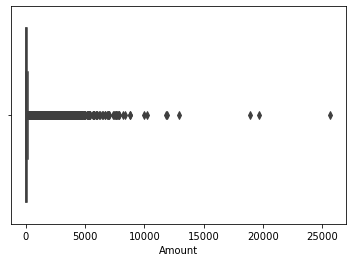

In [3]:
sns.boxplot(df['Amount']) 

In [4]:
print(df['Amount'].max())

25691.16


In [5]:
df.isnull().values.any()

False

In [6]:
# 27 most important features according to our EDA
cols = ['V'+str(i) for i in range(1, 29) if i != 25]
print(cols)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V26', 'V27', 'V28']


In [7]:
X = df[cols]
y = df['Class'] 

In [8]:
val_count = df['Class'].value_counts()
weights = dict(1 / val_count) # to be used as class weights
weights

{0: 3.51722561243691e-06, 1: 0.0020325203252032522}

In [9]:
val_count

0    284315
1       492
Name: Class, dtype: int64

In [10]:
admin_cost = 2.5

In [11]:
# defining a function to calculate cost savings
def cost_saving(ytrue, ypred, amount):
    fp = np.sum((ytrue == 0) & (ypred == 1))
    cost = np.sum(fp*admin_cost) + np.sum((amount[(ytrue == 1) & (ypred == 0)]))
    max_cost = np.sum((amount[(ytrue == 1)]))
    savings = 1 - (cost/max_cost)
    
    return savings

In [12]:
cv = StratifiedKFold(n_splits=4, random_state=1,shuffle=True)

In [13]:
# defining a function to calculate cost saving per fold (splits) of our cv
def cost_saving_per_split(scores, x, y, cv_object):
    results = []
    for i, (_, test_ind) in zip(range(cv_object.n_splits), cv_object.split(x, y)):
        ypred = scores['estimator'][i].predict(x[test_ind])
        ytrue = y[test_ind]
        amount = df['Amount'].values[test_ind]
        results.append(cost_saving(ytrue, ypred, amount))
        
    return results

In [14]:
# defining a function to return a dataframe of metrics results for each fold in our cv
def get_metric_scores(scores, x, y=y, cv_object=cv):
    ind = ['split_'+str(n) for n in range(1, cv_object.n_splits+1)]
    
    scores_df = pd.DataFrame(index=ind)
    
    scores_df['f1_score'] = scores['test_f1']
    scores_df['auc_pr'] = scores['test_average_precision']
    scores_df['cost_savings'] = cost_saving_per_split(scores, x, y, cv_object)

    return scores_df

In [15]:
# scaling the features
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
#scaler = StandardScaler()
#scaled_X = scaler.fit_transform(X)

In [16]:
from sklearn.pipeline import Pipeline

In [17]:
#fraud_sensitive_model = OneClassSVM(kernel='sigmoid',degree=3,gamma=0.1,nu=0.05,max_iter=-1)
fraud_sensitive_model = SVC(kernel='sigmoid',degree=3,gamma=0.1,max_iter=-1)

In [18]:
fraud_sensitive_scaler =MinMaxScaler()

fraud_sensitive_pipe = Pipeline([('scaler', fraud_sensitive_scaler), ('model', fraud_sensitive_model)])


In [19]:
fraud_sensitive_scores = cross_validate(fraud_sensitive_pipe, np.array(X), y, \
                            scoring=['f1', 'average_precision'], cv=cv, n_jobs=4, \
                                        return_estimator=True, error_score='raise')

In [20]:
fraud_sensitive_scores

{'fit_time': array([19.42932963, 20.90509295, 20.52165747, 20.04266453]),
 'score_time': array([8.82658434, 8.98893952, 8.72526503, 9.04351568]),
 'estimator': (Pipeline(steps=[('scaler', MinMaxScaler()),
                  ('model', SVC(gamma=0.1, kernel='sigmoid'))]),
  Pipeline(steps=[('scaler', MinMaxScaler()),
                  ('model', SVC(gamma=0.1, kernel='sigmoid'))]),
  Pipeline(steps=[('scaler', MinMaxScaler()),
                  ('model', SVC(gamma=0.1, kernel='sigmoid'))]),
  Pipeline(steps=[('scaler', MinMaxScaler()),
                  ('model', SVC(gamma=0.1, kernel='sigmoid'))])),
 'test_f1': array([0.55208333, 0.66326531, 0.59139785, 0.6       ]),
 'test_average_precision': array([0.66000286, 0.78352259, 0.7446042 , 0.72082864])}

In [21]:
fraud_sensitive_results = get_metric_scores(fraud_sensitive_scores, np.array(X))
fraud_sensitive_results

,f1_score,auc_pr,cost_savings
split_1,0.552083,0.660003,0.292319
split_2,0.663265,0.783523,0.392122
split_3,0.591398,0.744604,0.399150
split_4,0.600000,0.720829,0.275112


In [22]:
fraud_sensitive_results.mean()

f1_score        0.601687
auc_pr          0.727240
cost_savings    0.339676
dtype: float64

## Cost Sensitive Model

In [23]:
sample_weights = np.array([df['Amount'][ind] if fraud else admin_cost for ind, fraud in enumerate(y)])

In [24]:
scaler2 = MinMaxScaler()

cost_sensitive_model = SVC(kernel='sigmoid',degree=3,gamma=0.1,max_iter=-1)

cost_sensitive_pipe = Pipeline([('scaler', scaler2), ('model', cost_sensitive_model)])

cost_sensitive_scores = cross_validate(cost_sensitive_pipe, np.array(X), y, \
                        scoring=['f1', 'average_precision'], cv=cv, n_jobs=4, return_estimator=True, \
                          fit_params={'model__sample_weight': sample_weights}, error_score='raise')

In [25]:
cost_sensitive_results = get_metric_scores(cost_sensitive_scores, np.array(X))
cost_sensitive_results

,f1_score,auc_pr,cost_savings
split_1,0.755020,0.655181,0.722963
split_2,0.692857,0.697293,0.735942
split_3,0.809917,0.719562,0.815452
split_4,0.763780,0.705055,0.733003


In [26]:
cost_sensitive_results.mean()

f1_score        0.755394
auc_pr          0.694273
cost_savings    0.751840
dtype: float64

## Cost Sensitive Model SMOTE

In [ ]:
#from imblearn.pipeline import Pipeline

In [ ]:
#scaler3 = MinMaxScaler()

In [ ]:
#smote = SMOTE(random_state=1)
#smote_model = SVC(kernel='sigmoid')
#pipe_smote = Pipeline([('scaler', scaler3), ('smote', smote), ('model', smote_model)])

In [ ]:
#print(len(sample_weights))
#print(X.shape)


In [ ]:
#np.array(X).shape

In [ ]:
#smote_scores = cross_validate(pipe_smote, np.array(X), y, scoring=['f1', 'average_precision'], 
 #                             cv=cv, n_jobs=4, return_estimator=True,error_score='raise')

In [ ]:
#smote_scores

In [ ]:
#scaler = StandardScaler()
#scaled_X = scaler.fit_transform(X)

In [ ]:
smote_results = get_metric_scores(smote_scores, np.array(X))
smote_results

## BMR model

In [27]:
scaler3 = MinMaxScaler()
bmr_model = SVC(kernel='sigmoid',degree=3,gamma=0.1,max_iter=-1,probability=True)

bmr_pipe = Pipeline([('scaler', scaler3), ('model', bmr_model)])

bmr_scores = cross_validate(bmr_pipe, np.array(X), y, cv=cv, n_jobs=4, return_estimator=True, \
                            error_score='raise')

In [28]:
def bmr_predict(model, x, trans_cost):
    prob = model.predict_proba(x)[:, 1]
        
    expected_cost_0 = prob * trans_cost
    expected_cost_1 = (1-prob) * admin_cost
        
    pred = (expected_cost_1 < expected_cost_0).astype(int)
    return pred

In [29]:
def get_bmr_metric_scores(scores, x, y=y, cv_object=cv):
    ind = ['split_'+str(n) for n in range(1, cv_object.n_splits+1)]
    scores_df = pd.DataFrame(index=ind)

    f1_results = []
    cs_results = []
    
    for i, (_, test_ind) in zip(range(cv_object.n_splits), cv_object.split(x, y)):
        amount = df['Amount'].values[test_ind]
        
        ypred = bmr_predict(scores['estimator'][i], x[test_ind], amount)
        ytrue = y[test_ind]
                
        f1_results.append(f1_score(ytrue, ypred))
        cs_results.append(cost_saving(ytrue, ypred, amount))
        
    scores_df['f1_score'] = f1_results
    #scores_df['auc_pr'] = scores['test_average_precision']
    scores_df['cost_savings'] = cs_results

    return scores_df

In [30]:
bmr_results = get_bmr_metric_scores(bmr_scores, np.array(X))
bmr_results

,f1_score,cost_savings
split_1,0.683544,0.734395
split_2,0.713693,0.745513
split_3,0.736364,0.811054
split_4,0.687783,0.732184


In [31]:
bmr_results.mean()

f1_score        0.705346
cost_savings    0.755787
dtype: float64

In [32]:
fraud_sensitive_scaler =StandardScaler()

fraud_sensitive_pipe = Pipeline([('scaler', fraud_sensitive_scaler), ('model', fraud_sensitive_model)])


In [33]:
fraud_sensitive_scores = cross_validate(fraud_sensitive_pipe, np.array(X), y, \
                            scoring=['f1', 'average_precision'], cv=cv, n_jobs=4, \
                                        return_estimator=True, error_score='raise')

In [34]:
fraud_sensitive_results = get_metric_scores(fraud_sensitive_scores, np.array(X))
fraud_sensitive_results

,f1_score,auc_pr,cost_savings
split_1,0.311111,0.208385,0.233727
split_2,0.457143,0.355747,0.436080
split_3,0.466960,0.325084,0.402590
split_4,0.476190,0.346980,0.347837


In [35]:
fraud_sensitive_results.mean()

f1_score        0.427851
auc_pr          0.309049
cost_savings    0.355058
dtype: float64